# Imports

In [1]:
%%capture
!pip install yfinance
!pip install pytorch-lightning
!pip install scikit-plot

In [2]:
# Usual Imports
import yfinance as yf
import pandas as pd
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import torch
import random
from datetime import datetime
import datetime


# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Pytorch Lighnting tools : 
import pytorch_lightning as pl 
from pytorch_lightning.metrics.functional import accuracy
from pytorch_lightning.callbacks import ModelCheckpoint

# to show images
import numpy as np
import matplotlib.pyplot as plt

# to show the matrix 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import scikitplot as skplt

# Sklearn tools 
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler


In [3]:
current_device_name = torch.cuda.get_device_name(torch.cuda.current_device())
print('Using device:', current_device_name)

Using device: NVIDIA GeForce RTX 3070 Laptop GPU


# DATASET

In [4]:
class generate_dataset(Dataset):
    def __init__(self, start_date_df, end_date_df, SP_base_colums, VIX_base_colums, list_SP_returns_columns, 
                 list_VIX_returns_columns, list_SP_percent_columns, list_VIX_percent_columns,
                 list_SP_vol_columns, list_VIX_vol_columns, list_col_to_MAs, MA_list, t_list, size_window):
        """
        Pytorch Dataset to:
        """
        super(generate_dataset, self).__init__()
        # PARAMETERS
        self.start_date_df = start_date_df
        self.end_date_df = end_date_df
        self.SP_base_colums = SP_base_colums 
        self.VIX_base_colums = VIX_base_colums
        self.list_SP_returns_columns = list_SP_returns_columns
        self.list_VIX_returns_columns = list_VIX_returns_columns
        self.list_SP_percent_columns = list_SP_percent_columns
        self.list_VIX_percent_columns = list_VIX_percent_columns
        self.list_SP_vol_columns = list_SP_vol_columns
        self.list_VIX_vol_columns = list_VIX_vol_columns
        self.list_col_to_MAs = list_col_to_MAs
        self.A_range, self.B_range = MA_list, MA_list
        self.t_list = t_list
        self.size_window = size_window
        # GET DATAS
        self.SP500_df, self.VIX_df = self.prepare_data()
        self.SP500_df, self.VIX_df = self.feature_engineering()
        self.df_concat = self.concat_df()
        self.full_data = self.normalize()
        self.output_data=self.input_to_output_data()
        self.dataset = self.two_datasets_to_x_y()
    def __getitem__(self, idx):
        return self.dataset[idx]
    def prepare_data(self):
        #LOAD
        SP500_df = yf.download('^GSPC', start=self.start_date_df, end=self.end_date_df, progress=False)
        VIX_df = yf.download('^VIX', start=self.start_date_df, end=self.end_date_df, progress=False)
        return SP500_df, VIX_df
    def feature_engineering(self):
        SP500_df = self.SP500_df
        VIX_df = self.VIX_df
        #Returns
        for col in self.list_SP_returns_columns:
            SP500_df = self.get_returns(SP500_df, col)
        for col in list_VIX_returns_columns:
            VIX_df = self.get_returns(VIX_df, col)
        #Percents
        for col in self.list_SP_percent_columns:
            SP500_df = self.get_percent_changes(SP500_df, col)
        for col in self.list_VIX_percent_columns:
            VIX_df = self.get_percent_changes(VIX_df, col)
        #MVar    
        for col in self.list_SP_vol_columns:
            SP500_df = self.compute_MVar(SP500_df, self.t_list, col)
        for col in list_VIX_vol_columns:
            VIX_df = self.compute_MVar(VIX_df, self.t_list, col)
        #MAs
        for col in self.list_col_to_MAs:
            SP500_df = self.compute_MA_metrics(SP500_df, self.A_range, self.B_range, col)
        SP500_df=SP500_df.dropna()
        VIX_df=VIX_df.dropna()
        return SP500_df, VIX_df
    def concat_df(self):
        SP500_df = self.SP500_df
        VIX_df = self.VIX_df
        for key in VIX_df.keys() : VIX_df=VIX_df.rename(columns={key: "VIX" + key})
        for key in SP500_df.keys() : SP500_df=SP500_df.rename(columns={key: "SP" + key})
        full_data=pd.concat((SP500_df,VIX_df),axis=1, join="inner")
        return full_data
    def normalize(self):
        full_data = self.df_concat
        scaler = MinMaxScaler(feature_range=(-1, 1))
        for col in full_data.columns:
            full_data[col] = scaler.fit_transform(full_data[col].values.reshape(-1,1))
        return full_data
    def input_to_output_data(self):
        data=self.full_data["SPClose"].reset_index().copy() #.copy() ou travaille directement sur full_data
        # elements are changed one by one starting at the end
        for row in range(len(data["SPClose"])-1,0,-1) :
            if data.loc[data.index[row], "SPClose"]>=data.loc[data.index[row-1], "SPClose"] : # iloc
                data.loc[data.index[row], "SPClose"]=1
            else : data.loc[data.index[row], "SPClose"] = -1
        # first elements are not useful  
        data=data.drop(data.index[0:self.size_window]) 
        data=data.set_index("Date")
        return data
    def two_datasets_to_x_y(self):
        list_of_x_y = []
        # i th element in y
        index_i = 0
        # last row of input is not used as there is no y fo it
        data_x = self.full_data.drop(self.full_data.tail(1).index)
        data_y = self.output_data
        data_y = (data_y+1)/2 # to 0, 1
        for xi in data_x.rolling(self.size_window) :
            if len(xi)==self.size_window :
                #pdb.set_trace()
                list_of_x_y.append((torch.tensor([xi.values]).reshape([xi.shape[0], xi.shape[1]]).to(dtype=torch.float32),torch.tensor(data_y["SPClose"][index_i]).reshape([1]).to(torch.float32))) #.to(dtype=torch.float32)
                index_i+=1
        return list_of_x_y    
    ###############Feature Engineering
    def get_returns(self, df, col):
        df[col + '_return'] = df[col] - df[col].shift(1)
        return df
    def get_percent_changes(self, df, col):
        df[col + '_percent'] = df[col + '_return']/df[col].shift(1)
        return df
    def compute_MVar(self, df, t_list, col):
        for t in t_list:
            df['MVar_'+str(t)] = df[col].rolling(t).std()   
        return df
    def compute_MA(self, df, MA_list, col):
        for N in MA_list:
            df['MA'+str(N)] = df[col].rolling(N).mean()   
        return df
    def crossing_moving_average(self, df, A, B):
        df['MA'+str(A)+'>MA'+str(B)] =(df['MA'+str(A)] - df['MA'+str(B)])
        return df
    def compute_crossing_MA(self, df, MA_list):
        couples_MA = list(combinations(MA_list, 2))
        for couple in couples_MA:
            df = self.crossing_moving_average(df, couple[0], couple[1])   
        return df  
    def compute_percent_to_MA(self, df, MA_list, col):
        for N in MA_list:
            df['percent_to_MA'+str(N)] = (df[col] - df['MA'+str(N)])/df[col]
        return df
    def compute_MA_metrics(self, df, A_range, B_range, col):
        MA_list = list(set(A_range + B_range))
        df = self.compute_MA(df, MA_list, col)
        df = self.compute_crossing_MA(df, MA_list)
        df = self.compute_percent_to_MA(df, MA_list, col)
        return df

Je choisis ici ma liste de features à inclure dans mon dataset avec la classe generate_dataset. Cette dernière performe les mêmes opérations que pour le model CNN :
- On charge chaque dataset (VIX & SP500)
- On procède à du feature engineering (Returns, Percent Changes, Moving Variances, Moving Averages)
- On normalise avec MinMaxScaler
- Puis on découpe notre dataset en fenêtre de longueur 20, ces séries temporelles de 20 trading days représentent nos inputs, pour lesquels on cherche à prédire le signe du return le jour d'après.


La liste finale des paramètres choisis pour notre dataset se trouve ci-dessous. Nous avons choisi ici de rester parcimonieux afin d'éviter d'avoir besoin de structures trop complexes :

In [5]:
# PARAMETERS
start_date_df = '2005-01-31'
end_date_df = '2021-01-31'
SP_base_colums = ['Open', 'High', 'Low', 'Close', 'Volume']  #Adj Close ?
VIX_base_colums = ['Open', 'High', 'Low', 'Close']  #Adj Close ?
list_SP_returns_columns = ['Open', 'Close'] #SP_base_colums
list_VIX_returns_columns = ['Open', 'Close'] #VIX_base_colums
list_SP_percent_columns = ['Open', 'Close'] #SP_base_colums
list_VIX_percent_columns = ['Open', 'Close'] #VIX_base_colums
list_SP_vol_columns = ['Close'] #SP_base_colums
list_VIX_vol_columns = ['Close'] #VIX_base_colums
list_col_to_MAs = ['Close'] 
MA_list = [5, 20] #[5, 10, 25, 99]
A_range, B_range = MA_list, MA_list
t_list = [20]
size_window = 20

In [6]:
data = generate_dataset(start_date_df, end_date_df, SP_base_colums, VIX_base_colums, list_SP_returns_columns, 
                 list_VIX_returns_columns, list_SP_percent_columns, list_VIX_percent_columns,
                 list_SP_vol_columns, list_VIX_vol_columns, list_col_to_MAs, MA_list, t_list, size_window)
dataset = data.dataset

Ainsi un élément du dataset est une série de 20 points (~trading days), comprenant 27 features :

In [159]:
data.dataset[0][0].shape

torch.Size([20, 27])

On créer ensuite un Datamodule pour générer nos batchs :

In [7]:
class DataModule(pl.LightningDataModule):
    def __init__(self, dataset, test_threshold, val_threshold, num_workers, batch_size, batch_size_val):
        super(DataModule, self).__init__()
        self.num_workers = num_workers
        self.batch_size = batch_size
        self.batch_size_val = batch_size_val
        self.dataset = dataset
        #self.dataset = self.prepare_data()
        self.test_threshold = test_threshold
        self.val_threshold = val_threshold
    def prepare_data(self):
        pass 
    def randomsample(self):
        dataset = random.sample(self.dataset, len(self.dataset))
        return dataset
    def setup(self, stage):
        if stage == 'test' or stage is None:
            stop_test = int(self.test_threshold*len(self.dataset))
            self.testset = self.dataset[stop_test+1:]
        if stage == 'fit' or stage is None:
            stop_test = int(self.test_threshold*len(self.dataset))
            self.fullset = random.sample(self.dataset[:stop_test+1], len(self.dataset[:stop_test+1])) 
            stop_val = int(val_threshold*len(self.fullset))
            self.trainset = self.fullset[:stop_val+1]
            self.valset = self.fullset[stop_val+1:]
    def train_dataloader(self):
        return DataLoader(self.trainset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True, sampler=None)
    def val_dataloader(self):
        return DataLoader(self.valset, batch_size=self.batch_size_val, num_workers=self.num_workers)
    def test_dataloader(self):
        return DataLoader(self.testset, batch_size=self.batch_size_val, num_workers=self.num_workers) 

In [8]:
# Parameters 
test_threshold = 0.9
val_threshold = 0.8
num_workers = 0
batch_size = 128
batch_size_val = 512
datamodule = DataModule(dataset, test_threshold, val_threshold, num_workers, batch_size, batch_size_val) # num_workers=4

In [9]:
datamodule.setup('fit')
print('Train+Val set size:', len(datamodule.fullset))
datamodule.setup('test')
print('Testset size:', len(datamodule.testset))

Train+Val set size: 3591
Testset size: 398


In [10]:
train_loader_final = datamodule.train_dataloader()
train_iter = iter(train_loader_final)
x,y = next(train_iter)

In [11]:
x.size()

torch.Size([128, 20, 27])

In [12]:
y.size()

torch.Size([128, 1])

# Model Training

On choisit un modèle LSTM basique du module Pytorch dont les paramètres principaux seront :
- Le nombre de layers (num_layers)
- Le nombre de neurones (hidden_size)
- Ainsi que le paramètre de dropout (dropout).

In [13]:
# scale après ?
class LSTM(pl.LightningModule):
    '''
    LSTM Model
    '''
    def __init__(self, batch_size, criterion, learning_rate, n_features, hidden_size, num_layers, dropout):
        super(LSTM, self).__init__()
        #Parameters
        self.batch_size = batch_size
        self.criterion = criterion
        self.learning_rate = learning_rate
        #architecture
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden_size, num_layers=num_layers,
                            dropout=dropout, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x) #(batch_size, seq_len, hidden_size)
        y_pred = self.linear(lstm_out[:,-1])
        return y_pred
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    
    def iter_step(self, batch, batch_idx, step):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        acc = accuracy(torch.sigmoid(y_hat), ((y+1)/2).type(torch.LongTensor).cuda())
        self.log(step + '_loss', loss, prog_bar=True, logger=True)
        self.log(step +'_acc', acc, prog_bar=True, logger=True)
        return loss, acc
    
    def training_step(self, batch, batch_idx):
        loss, acc = self.iter_step(batch, batch_idx, 'train')
        return {"loss": loss, "acc": acc}

    def validation_step(self, batch, batch_idx):
        loss, acc = self.iter_step(batch, batch_idx, 'val')
        return {"loss": loss, "acc": acc} 
    
    def test_step(self, batch, batch_idx):
        loss, acc = self.iter_step(batch, batch_idx, 'test')
        return {"loss": loss, "acc": acc}

In [14]:
batch_size = 128
batch_size_val = 512
max_epochs = 1000
learning_rate = 0.001
criterion = nn.BCEWithLogitsLoss()
n_features = x.size()[2]
hidden_size = 100
num_layers = 1
dropout = 0.5
model = LSTM(batch_size, criterion, learning_rate, n_features, hidden_size, num_layers, dropout)

C:\Users\ADRIEN\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


On commence par tester la forward pass avec des paramètres randoms :

In [38]:
logits = model(x) # pass forward

In [39]:
logits.size()

torch.Size([128, 1])

In [40]:
y.size()

torch.Size([128, 1])

In [42]:
# forward pass, loss computation oks
loss = nn.BCEWithLogitsLoss()
loss(logits, y) 
# forward pass, loss computation oks

tensor(0.7064, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

Ensuite on décide d'ici d'appliquer des poids à nos classes, car notre dataset est imbalanced et notre réseau semble overfitter la classe surreprésenté. Pour cela on étudie la répartition des classes dans notre dataset de train :

In [47]:
datamodule = DataModule(dataset, test_threshold, val_threshold, num_workers, 100000, batch_size_val) # num_workers=4
datamodule.setup('fit')
Trainloader = datamodule.train_dataloader()
train_iter = iter(Trainloader)
x_train,y_train = next(train_iter)
targets = y_train #((y_train+1)/2) 
print(targets.sum())
print(len(targets))
# 2181 "1" / 2816 "0" ("-1")

tensor(2181.)
2816


On applique alors cette répartition au poids appliqué à la loss. On choisit ici une Loss Binary Cross Entropy, faisait ainsi de notre LSTM un classifieur.
On utilise un Checkpoint qui sélectionne l'epoch qui minimise la loss.

Le learning rate  a un impact énorme sur l'entraînement du réseau, certaines valeurs le faisant stagner tandis que d'autres entraîne un overfitting flaggrant sur les graphiques. Num_layer et hidden_size également, mais trop les réduire semblent réduire la performance. Il nous a fallu jouer entre ces paramètres et le dropout pour arriver à un résultat "satisfaisant".

In [65]:
batch_size = 128
batch_size_val = 512
max_epochs = 2000
learning_rate = 0.00005#0.00005
criterion = nn.BCEWithLogitsLoss(weight = torch.FloatTensor([2181/2816]).cuda() , reduction='mean')
n_features = x.size()[2]
hidden_size = 100
num_layers = 2
dropout = 0.5
dm = DataModule(dataset, test_threshold, val_threshold, num_workers, batch_size, batch_size_val) # num_workers=4
model_checkpoint = ModelCheckpoint(monitor="val_loss", filename="{epoch}_{val_loss:.4f}", save_top_k=1, mode='min')
trainer = pl.Trainer(gpus=1, max_epochs=max_epochs, progress_bar_refresh_rate=20, checkpoint_callback=model_checkpoint)
model = LSTM(batch_size, criterion, learning_rate, n_features, hidden_size, num_layers, dropout)

trainer.fit(model, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | lstm      | LSTM              | 51.6 K
2 | linear    | Linear            | 101   
------------------------------------------------
51.7 K    Trainable params
0         Non-trainable params
51.7 K    Total params
0.207     Total estimated model params size (MB)


1

On peut voir sur les graphs les difficultés que l'on a eu à entraîner ce réseau. En effet il était très difficile de ne pas overfitter nos données tout en faisant apprendre quelque chose à notre réseau.

In [36]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 33972), started 1 day, 9:31:43 ago. (Use '!kill 33972' to kill it.)

# Tests

Dans cette section on teste la performance finale de notre réseau, pour cela on utilise les métriques classiques :
- Classification Report
- Confusion Matrix
- Roc Curve / Roc AUC

In [22]:
# Useful functions
import scikitplot as skplt

def get_predictions(model, loader, checkpoint_path, load_bool):
    all_preds = torch.tensor([]).detach()
    if load_bool:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['state_dict'])
    for batch in loader:
        #pdb.set_trace()
        images, labels = batch
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds.detach()

def plot_roc_curve(y_test, y_score, title=None, label=None, legend=True, 
                   show_thresholds=False, colorbar=True):
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    thresholds[0] = 1
    roc_auc = roc_auc_score(y_test, y_score)
    if label is None:
        label='ROC curve (area = %0.2f)' % roc_auc
    if title is None:
        title = "ROC curve"
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    
    if show_thresholds:
        norm = plt.Normalize(vmin=0, vmax=1)
        plt.plot(fpr, tpr, lw=1, label=label, alpha=0.7)
        plt.scatter(fpr, tpr, cmap=cm, c=thresholds, s=70, norm=norm)
        if colorbar:
            plt.colorbar()
    else:
        plt.plot(fpr, tpr, lw=3, label=label)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(title, fontsize=16)
    if legend:
        plt.legend(fontsize=12)

In [126]:
# Test phase
best_checkpoint = trainer.checkpoint_callback.best_model_path
print(best_checkpoint)
trainer.test(model, datamodule=dm, ckpt_path=best_checkpoint)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


C:\Users\ADRIEN\Downloads\lightning_logs\version_67\checkpoints\epoch=198_val_loss=0.5344.ckpt



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.5769230723381042, 'test_loss': 0.5322272181510925}
--------------------------------------------------------------------------------


[{'test_loss': 0.5322272181510925, 'test_acc': 0.5769230723381042}]

In [38]:
# Get predictions (test) 
datamodule = DataModule(dataset, test_threshold, val_threshold, num_workers, batch_size, batch_size_val) # num_workers=4
datamodule.setup('test')
Testloader = datamodule.test_dataloader()
predictions = get_predictions(LSTM(batch_size, criterion, learning_rate, n_features, hidden_size, num_layers, dropout), Testloader, best_checkpoint, False)
scores = torch.sigmoid(predictions)

In [28]:
test_iter = iter(Testloader)
x_test,y_test = next(test_iter)
targets = y_test 

In [144]:
print(classification_report(targets, (scores>0.5)*1))

              precision    recall  f1-score   support

         0.0       0.52      0.08      0.15       165
         1.0       0.58      0.94      0.72       225

    accuracy                           0.58       390
   macro avg       0.55      0.51      0.43       390
weighted avg       0.56      0.58      0.48       390



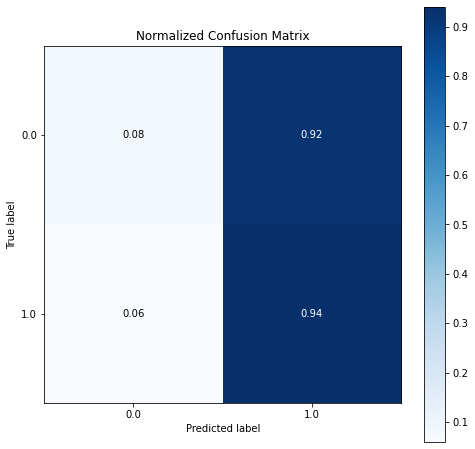

In [146]:
# Confusion Matrix
cm = confusion_matrix(targets, scores.argmax(dim=1))
skplt.metrics.plot_confusion_matrix(targets, (scores>0.5)*1, normalize=True, figsize=(8, 8))
plt.show()

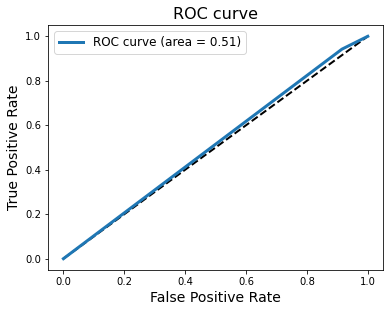

In [148]:
# Roc Curve
plt.figure(figsize=(6, 4.5))
plot_roc_curve(targets, (scores>0.5)*1)

Nos perfs sont globalement très décevantes ... Malgré nos efforts, notre réseau persiste à overfitter l'une des deux classes.

Un certain nombre d'améliorations aurait pu être envisagées :
- Faire un feature engineering plus complet.
- Procéder ensuite à une feature selection à l'aide d'une PCA, ou des features importances d'un Random Forest.
- Hyperoptimiser le réseau finement, à l'aide du module Ray par exemple.
- Procéder à du subsampling plutôt qu'utiliser des poids sur la loss, bien que ces approches soient censées être équivalentes.
On aurait aussi pu envisager une loss plus classique comme une MSELoss, notre modèle prédisant alors non plus le sens mais la valeur du prochain return.

# Ray Optimization